# MediaPipe Feature Analysis: Understanding 6516-Dimensional Features

## Overview
This notebook provides a deep analysis of the 6516-dimensional MediaPipe features extracted for sign language recognition. The analysis includes:

- Feature structure and composition breakdown
- Feature importance and informativeness analysis
- Correlation and redundancy analysis
- Compression strategy recommendations
- Visualizations for thesis documentation

**Purpose**: Understand feature characteristics to guide compression strategies for the student model (<100MB target) while maintaining recognition accuracy.

**Author**: Larry S.


In [ ]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import pearsonr
import platform
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality plotting style
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9

# Set random seed for reproducibility
np.random.seed(42)

# Create output directory
Path('figures').mkdir(exist_ok=True)

# Get system information
print(f"Python version: {platform.python_version()}")

Python version: 3.9.13


## 1. Feature Structure Analysis


In [3]:
# Define data paths
DATA_ROOT = Path('../data')
MEDIAPIPE_FEATURES = DATA_ROOT / 'teacher_features' / 'mediapipe_full'
ANNOTATIONS = DATA_ROOT / 'raw_data' / 'phoenix-2014-multisigner' / 'annotations' / 'manual'

# Load annotations for reference
train_df = pd.read_csv(ANNOTATIONS / 'train.corpus.csv', sep='|')

# Load a sample of MediaPipe features
def load_mediapipe_features(video_id, split='train'):
    """Load MediaPipe features for a video"""
    feature_path = MEDIAPIPE_FEATURES / split / f"{video_id}.npz"
    if feature_path.exists():
        data = np.load(feature_path, allow_pickle=True)
        return {
            'features': data['features'],
            'detection_masks': data['detection_masks'] if 'detection_masks' in data else None,
            'metadata': data['metadata'].item() if 'metadata' in data else None,
            'video_id': data['video_id'].item() if 'video_id' in data else video_id
        }
    return None

# Load sample features
sample_video = train_df['id'].iloc[0]
sample_features = load_mediapipe_features(sample_video, 'train')

if sample_features:
    print("=== Feature Structure Analysis ===")
    print(f"Feature shape: {sample_features['features'].shape}")
    print(f"Number of frames: {sample_features['features'].shape[0]}")
    print(f"Feature dimensions per frame: {sample_features['features'].shape[1]}")
    print(f"Feature dtype: {sample_features['features'].dtype}")
    print(f"\nExpected standard MediaPipe Holistic: 2172 features")
    print(f"Actual features: {sample_features['features'].shape[1]} features")
    print(f"Increase: {sample_features['features'].shape[1] / 2172:.2f}x")
    
    # Check metadata for feature breakdown if available
    if sample_features['metadata']:
        print(f"\nMetadata available: {type(sample_features['metadata'])}")
        if isinstance(sample_features['metadata'], dict):
            print(f"Metadata keys: {list(sample_features['metadata'].keys())}")


=== Feature Structure Analysis ===
Feature shape: (176, 6516)
Number of frames: 176
Feature dimensions per frame: 6516
Feature dtype: float32

Expected standard MediaPipe Holistic: 2172 features
Actual features: 6516 features
Increase: 3.00x

Metadata available: <class 'str'>


In [4]:
# Load multiple sequences for comprehensive analysis
def load_feature_batch(split='train', num_samples=200):
    """Load a batch of features for analysis"""
    feature_dir = MEDIAPIPE_FEATURES / split
    feature_files = list(feature_dir.glob('*.npz'))[:num_samples]
    
    all_features = []
    sequence_lengths = []
    video_ids = []
    
    for feature_file in feature_files:
        data = np.load(feature_file, allow_pickle=True)
        features = data['features']
        all_features.append(features)
        sequence_lengths.append(features.shape[0])
        video_ids.append(feature_file.stem)
    
    return {
        'features': all_features,
        'sequence_lengths': np.array(sequence_lengths),
        'video_ids': video_ids
    }

print("Loading feature batch for analysis...")
feature_batch = load_feature_batch('train', num_samples=200)

print(f"\n=== Batch Statistics ===")
print(f"Number of sequences: {len(feature_batch['features'])}")
print(f"Average sequence length: {np.mean(feature_batch['sequence_lengths']):.1f} frames")
print(f"Total frames: {sum(feature_batch['sequence_lengths'])}")
print(f"Feature dimensions: {feature_batch['features'][0].shape[1]}")


Loading feature batch for analysis...

=== Batch Statistics ===
Number of sequences: 200
Average sequence length: 143.3 frames
Total frames: 28661
Feature dimensions: 6516


## 2. Feature Distribution and Statistics


In [5]:
# Analyze feature distributions across all dimensions
def analyze_feature_statistics(feature_batch):
    """Compute comprehensive statistics for all feature dimensions"""
    # Concatenate all features
    all_features_concatenated = np.concatenate([f for f in feature_batch['features']], axis=0)
    
    feature_dim = all_features_concatenated.shape[1]
    
    # Compute statistics for each dimension
    feature_means = np.mean(all_features_concatenated, axis=0)
    feature_stds = np.std(all_features_concatenated, axis=0)
    feature_vars = np.var(all_features_concatenated, axis=0)
    feature_mins = np.min(all_features_concatenated, axis=0)
    feature_maxs = np.max(all_features_concatenated, axis=0)
    feature_ranges = feature_maxs - feature_mins
    
    # Compute coefficient of variation (std/mean) as measure of informativeness
    feature_cv = np.abs(feature_stds / (feature_means + 1e-8))  # Add small epsilon to avoid division by zero
    
    return {
        'means': feature_means,
        'stds': feature_stds,
        'vars': feature_vars,
        'mins': feature_mins,
        'maxs': feature_maxs,
        'ranges': feature_ranges,
        'coefficient_of_variation': feature_cv,
        'all_features': all_features_concatenated
    }

print("Computing feature statistics...")
feature_stats = analyze_feature_statistics(feature_batch)

print(f"\n=== Feature Statistics Summary ===")
print(f"Mean value across all features: {np.mean(feature_stats['means']):.4f}")
print(f"Std value across all features: {np.mean(feature_stats['stds']):.4f}")
print(f"Mean variance: {np.mean(feature_stats['vars']):.4f}")
print(f"Mean range: {np.mean(feature_stats['ranges']):.4f}")
print(f"Mean coefficient of variation: {np.mean(feature_stats['coefficient_of_variation']):.4f}")
print(f"\nFeatures with zero variance (constant): {np.sum(feature_stats['vars'] < 1e-8)}")
print(f"Features with very low variance (<0.001): {np.sum(feature_stats['vars'] < 0.001)}")


Computing feature statistics...

=== Feature Statistics Summary ===
Mean value across all features: 0.1410
Std value across all features: 0.0753
Mean variance: 0.0129
Mean range: 1.1460
Mean coefficient of variation: 942796.0000

Features with zero variance (constant): 8
Features with very low variance (<0.001): 2039


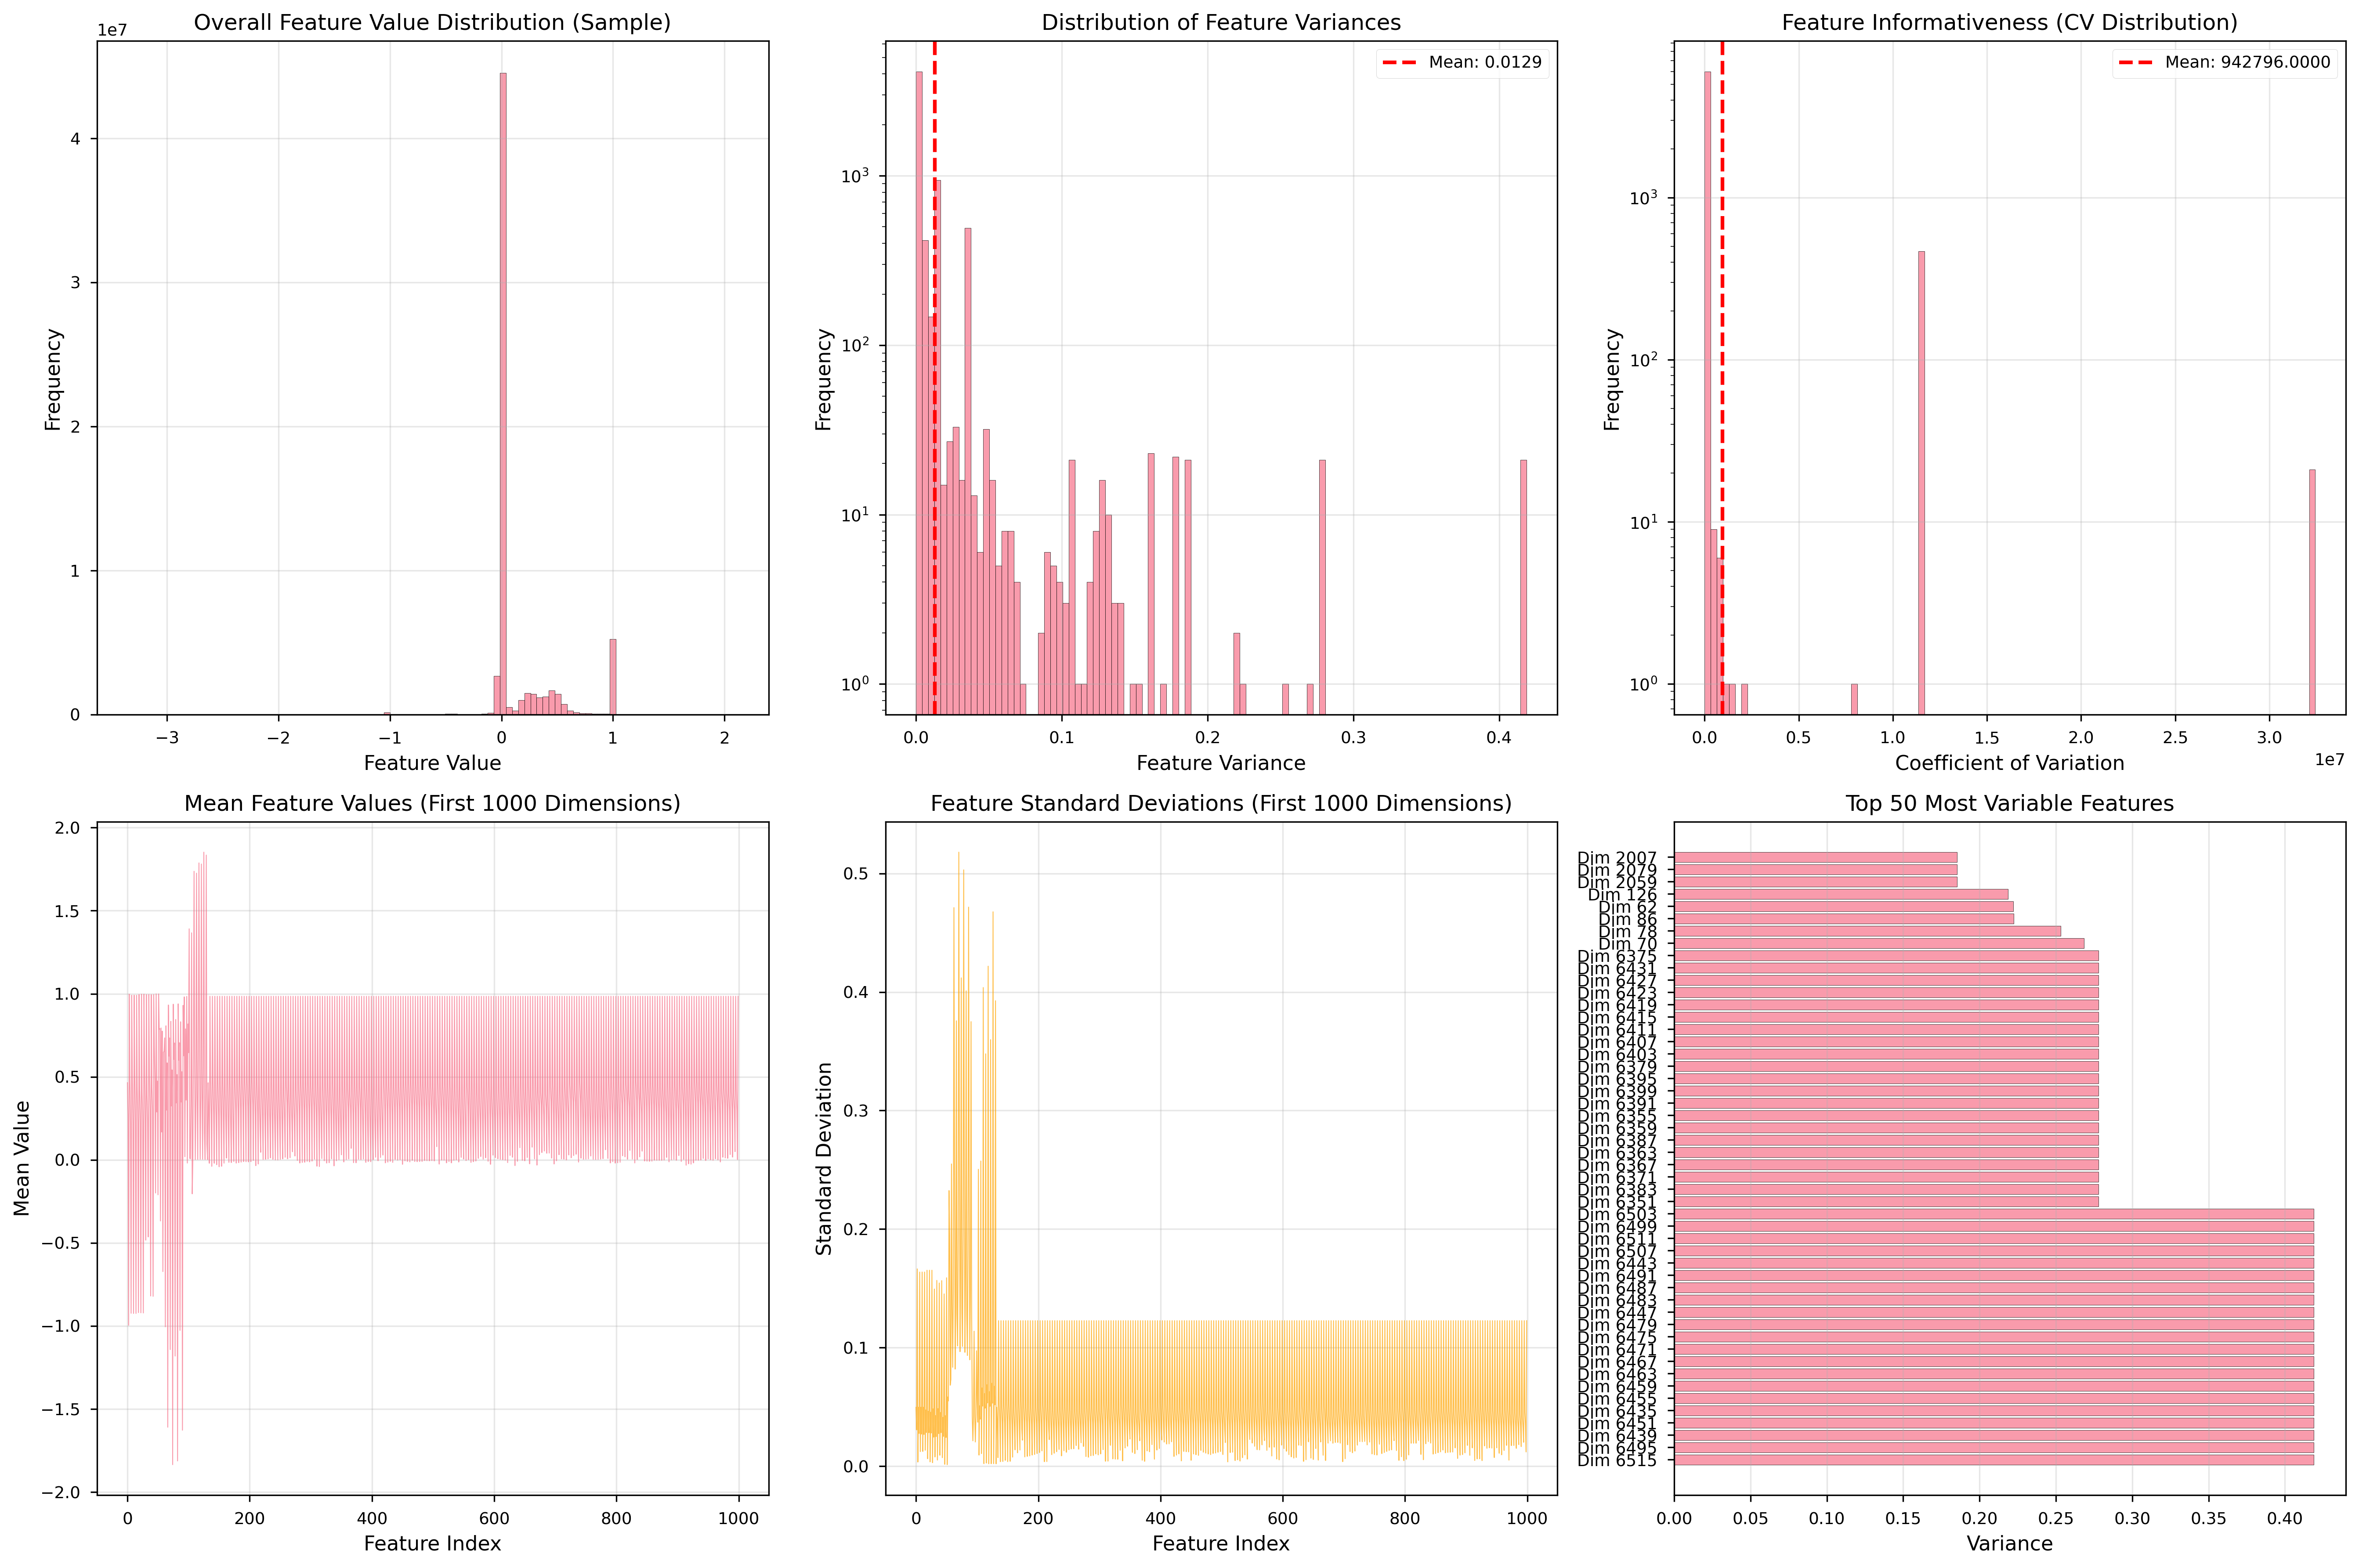

In [6]:
# Visualize feature distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Feature value distribution (sample of all features)
sample_features_flat = feature_stats['all_features'][:10000, :].flatten()  # Sample for speed
axes[0, 0].hist(sample_features_flat, bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Feature Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Overall Feature Value Distribution (Sample)')
axes[0, 0].grid(True, alpha=0.3)

# 2. Feature variance distribution
axes[0, 1].hist(feature_stats['vars'], bins=100, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(np.mean(feature_stats['vars']), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(feature_stats["vars"]):.4f}')
axes[0, 1].set_xlabel('Feature Variance')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Feature Variances')
axes[0, 1].legend()
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# 3. Coefficient of variation distribution
axes[0, 2].hist(feature_stats['coefficient_of_variation'], bins=100, edgecolor='black', alpha=0.7)
axes[0, 2].axvline(np.mean(feature_stats['coefficient_of_variation']), color='red', 
                   linestyle='--', linewidth=2, label=f'Mean: {np.mean(feature_stats["coefficient_of_variation"]):.4f}')
axes[0, 2].set_xlabel('Coefficient of Variation')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Feature Informativeness (CV Distribution)')
axes[0, 2].legend()
axes[0, 2].set_yscale('log')
axes[0, 2].grid(True, alpha=0.3)

# 4. Feature means across dimensions
axes[1, 0].plot(feature_stats['means'][:1000], alpha=0.7, linewidth=0.5)
axes[1, 0].set_xlabel('Feature Index')
axes[1, 0].set_ylabel('Mean Value')
axes[1, 0].set_title('Mean Feature Values (First 1000 Dimensions)')
axes[1, 0].grid(True, alpha=0.3)

# 5. Feature standard deviations
axes[1, 1].plot(feature_stats['stds'][:1000], alpha=0.7, linewidth=0.5, color='orange')
axes[1, 1].set_xlabel('Feature Index')
axes[1, 1].set_ylabel('Standard Deviation')
axes[1, 1].set_title('Feature Standard Deviations (First 1000 Dimensions)')
axes[1, 1].grid(True, alpha=0.3)

# 6. Top informative features (by variance)
top_variance_indices = np.argsort(feature_stats['vars'])[-50:][::-1]
axes[1, 2].barh(range(len(top_variance_indices)), feature_stats['vars'][top_variance_indices], 
                edgecolor='black', alpha=0.7)
axes[1, 2].set_yticks(range(len(top_variance_indices)))
axes[1, 2].set_yticklabels([f'Dim {idx}' for idx in top_variance_indices])
axes[1, 2].set_xlabel('Variance')
axes[1, 2].set_title('Top 50 Most Variable Features')
axes[1, 2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('figures/feature_distribution_analysis.png', bbox_inches='tight')
plt.show()


## 3. Feature Importance and Informativeness


In [7]:
# Identify most informative features using multiple criteria
def identify_important_features(feature_stats, top_k=100):
    """Identify most important features using multiple criteria"""
    
    # Sort by different criteria
    by_variance = np.argsort(feature_stats['vars'])[-top_k:][::-1]
    by_std = np.argsort(feature_stats['stds'])[-top_k:][::-1]
    by_cv = np.argsort(feature_stats['coefficient_of_variation'])[-top_k:][::-1]
    by_range = np.argsort(feature_stats['ranges'])[-top_k:][::-1]
    
    # Combine rankings (simple voting)
    feature_scores = np.zeros(feature_stats['vars'].shape[0])
    for rank, idx in enumerate(by_variance):
        feature_scores[idx] += (top_k - rank) / top_k
    for rank, idx in enumerate(by_std):
        feature_scores[idx] += (top_k - rank) / top_k
    for rank, idx in enumerate(by_cv):
        feature_scores[idx] += (top_k - rank) / top_k
    for rank, idx in enumerate(by_range):
        feature_scores[idx] += (top_k - rank) / top_k
    
    top_features = np.argsort(feature_scores)[-top_k:][::-1]
    
    return {
        'top_by_variance': by_variance,
        'top_by_std': by_std,
        'top_by_cv': by_cv,
        'top_by_range': by_range,
        'top_combined': top_features,
        'feature_scores': feature_scores
    }

feature_importance = identify_important_features(feature_stats, top_k=500)

print("=== Feature Importance Analysis ===")
print(f"Top 100 features by variance: {feature_importance['top_by_variance'][:10]}")
print(f"Top 100 features by coefficient of variation: {feature_importance['top_by_cv'][:10]}")
print(f"\nOverlap between top 100 variance and top 100 CV: "
      f"{len(set(feature_importance['top_by_variance'][:100]) & set(feature_importance['top_by_cv'][:100]))} features")


=== Feature Importance Analysis ===
Top 100 features by variance: [6515 6495 6439 6451 6435 6455 6459 6463 6467 6471]
Top 100 features by coefficient of variation: [4255 4235 4199 4207 4195 4211 4191 4215 4219 4187]

Overlap between top 100 variance and top 100 CV: 0 features


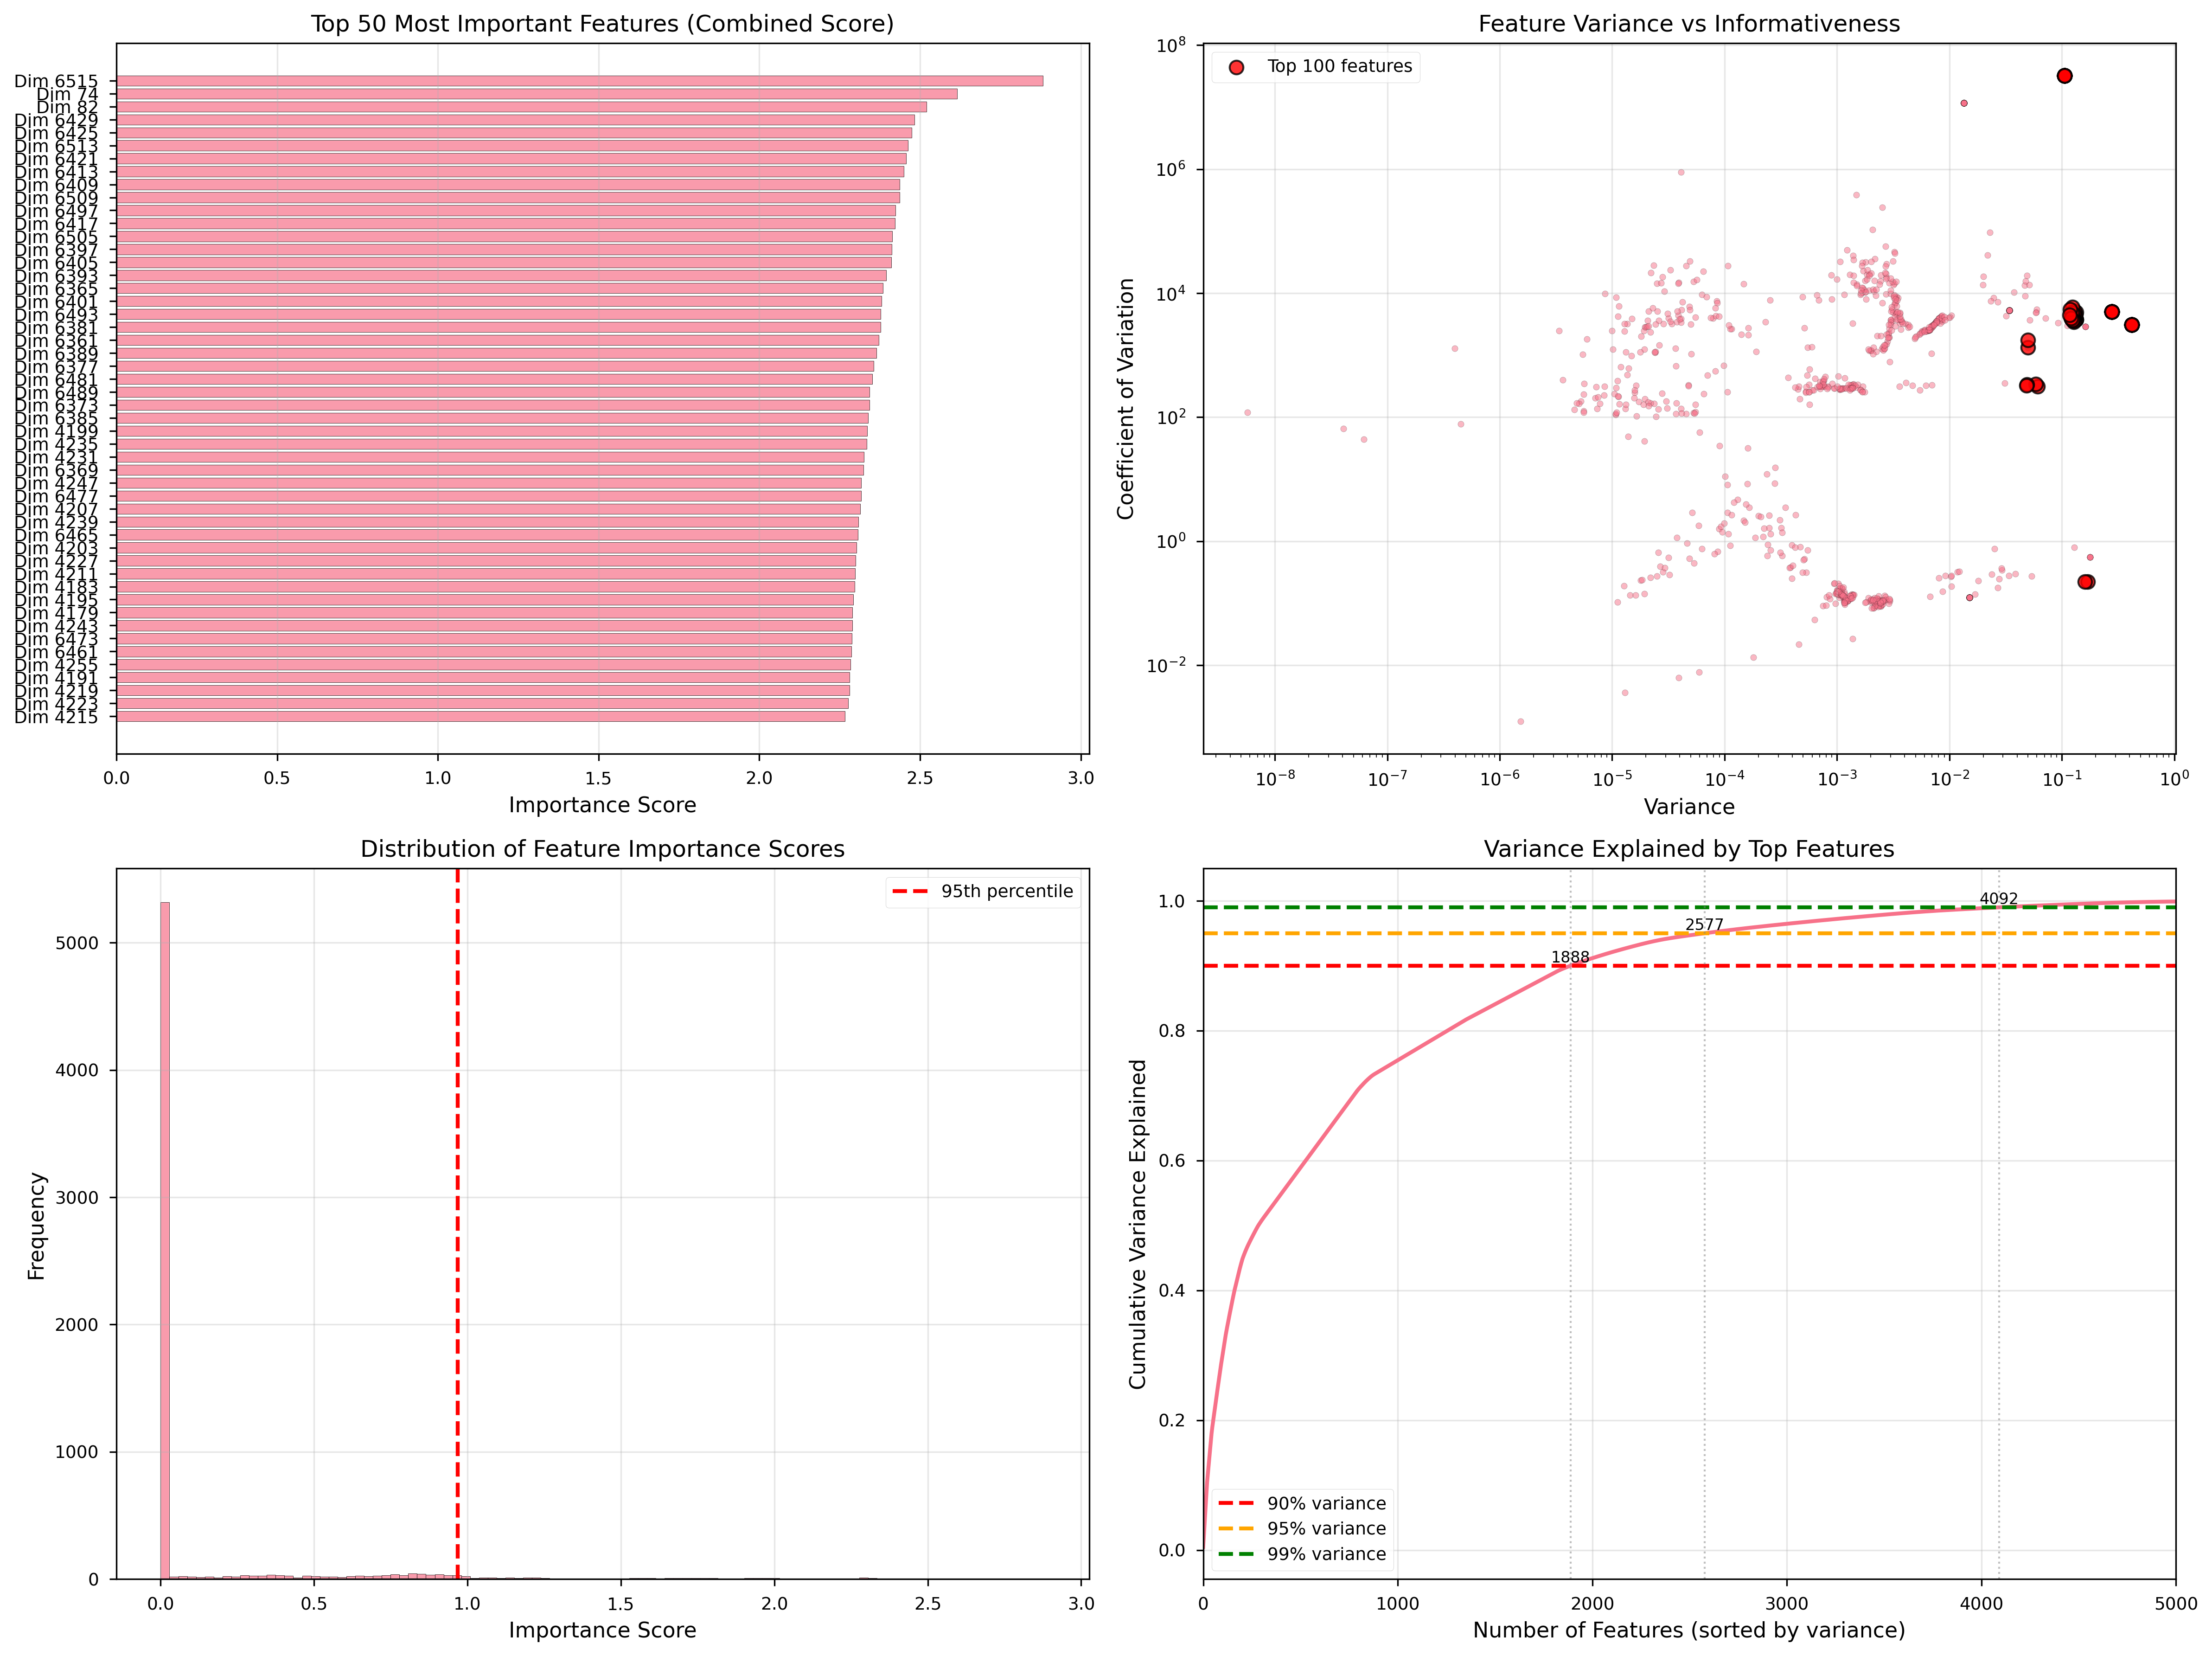


=== Compression Insights ===
90% variance explained by 1888 features (compression: 3.45x, 29.0% of original)
95% variance explained by 2577 features (compression: 2.53x, 39.5% of original)
99% variance explained by 4092 features (compression: 1.59x, 62.8% of original)


In [8]:
# Visualize feature importance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Feature importance scores
top_500_indices = feature_importance['top_combined'][:500]
axes[0, 0].barh(range(50), feature_importance['feature_scores'][top_500_indices[:50]][::-1], 
                edgecolor='black', alpha=0.7)
axes[0, 0].set_yticks(range(50))
axes[0, 0].set_yticklabels([f'Dim {idx}' for idx in top_500_indices[:50][::-1]])
axes[0, 0].set_xlabel('Importance Score')
axes[0, 0].set_title('Top 50 Most Important Features (Combined Score)')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# 2. Variance vs Coefficient of Variation scatter
sample_indices = np.random.choice(len(feature_stats['vars']), size=1000, replace=False)
axes[0, 1].scatter(feature_stats['vars'][sample_indices], 
                    feature_stats['coefficient_of_variation'][sample_indices],
                    alpha=0.5, s=10, edgecolors='black', linewidth=0.1)
axes[0, 1].set_xlabel('Variance')
axes[0, 1].set_ylabel('Coefficient of Variation')
axes[0, 1].set_title('Feature Variance vs Informativeness')
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# Highlight top features
top_100_indices = feature_importance['top_combined'][:100]
axes[0, 1].scatter(feature_stats['vars'][top_100_indices], 
                    feature_stats['coefficient_of_variation'][top_100_indices],
                    alpha=0.8, s=50, color='red', edgecolors='black', linewidth=1,
                    label='Top 100 features', zorder=5)
axes[0, 1].legend()

# 3. Feature importance distribution
axes[1, 0].hist(feature_importance['feature_scores'], bins=100, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(np.percentile(feature_importance['feature_scores'], 95), 
                   color='red', linestyle='--', linewidth=2, label='95th percentile')
axes[1, 0].set_xlabel('Importance Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Feature Importance Scores')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Cumulative variance explained by top features
sorted_variances = np.sort(feature_stats['vars'])[::-1]
cumulative_variance = np.cumsum(sorted_variances) / np.sum(feature_stats['vars'])
axes[1, 1].plot(range(len(cumulative_variance)), cumulative_variance, linewidth=2)
axes[1, 1].axhline(0.90, color='red', linestyle='--', linewidth=2, label='90% variance')
axes[1, 1].axhline(0.95, color='orange', linestyle='--', linewidth=2, label='95% variance')
axes[1, 1].axhline(0.99, color='green', linestyle='--', linewidth=2, label='99% variance')

# Find number of features needed for each threshold
for threshold in [0.90, 0.95, 0.99]:
    n_features = np.argmax(cumulative_variance >= threshold) + 1
    axes[1, 1].axvline(n_features, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    axes[1, 1].text(n_features, threshold, f'{n_features}', 
                    ha='center', va='bottom', fontsize=8)

axes[1, 1].set_xlabel('Number of Features (sorted by variance)')
axes[1, 1].set_ylabel('Cumulative Variance Explained')
axes[1, 1].set_title('Variance Explained by Top Features')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(0, min(5000, len(cumulative_variance)))

plt.tight_layout()
plt.savefig('figures/feature_importance_analysis.png', bbox_inches='tight')
plt.show()

# Print compression insights
print("\n=== Compression Insights ===")
for threshold in [0.90, 0.95, 0.99]:
    n_features = np.argmax(cumulative_variance >= threshold) + 1
    compression_ratio = len(feature_stats['vars']) / n_features
    print(f"{threshold*100:.0f}% variance explained by {n_features} features "
          f"(compression: {compression_ratio:.2f}x, {n_features/len(feature_stats['vars'])*100:.1f}% of original)")


## 4. Correlation and Redundancy Analysis


In [9]:
# Analyze feature correlations (sample to avoid memory issues)
def analyze_correlations(feature_stats, sample_size=1000, max_features=500):
    """Analyze correlations between features"""
    # Sample features and frames
    all_features = feature_stats['all_features']
    
    # Sample frames
    if all_features.shape[0] > sample_size:
        frame_indices = np.random.choice(all_features.shape[0], size=sample_size, replace=False)
        sampled_features = all_features[frame_indices, :]
    else:
        sampled_features = all_features
    
    # Sample feature dimensions (top variable ones)
    top_var_indices = np.argsort(feature_stats['vars'])[-max_features:][::-1]
    sampled_features = sampled_features[:, top_var_indices]
    
    # Compute correlation matrix
    correlation_matrix = np.corrcoef(sampled_features.T)
    
    # Find highly correlated feature pairs
    np.fill_diagonal(correlation_matrix, 0)  # Remove self-correlations
    high_corr_pairs = np.where(np.abs(correlation_matrix) > 0.9)
    
    return {
        'correlation_matrix': correlation_matrix,
        'high_corr_pairs': high_corr_pairs,
        'top_var_indices': top_var_indices,
        'mean_abs_correlation': np.mean(np.abs(correlation_matrix))
    }

print("Analyzing feature correlations (this may take a moment)...")
corr_analysis = analyze_correlations(feature_stats, sample_size=5000, max_features=500)

print(f"\n=== Correlation Analysis ===")
print(f"Mean absolute correlation: {corr_analysis['mean_abs_correlation']:.4f}")
print(f"Number of highly correlated pairs (|r| > 0.9): {len(corr_analysis['high_corr_pairs'][0])}")
print(f"Percentage of highly correlated pairs: {len(corr_analysis['high_corr_pairs'][0]) / (500*499/2) * 100:.2f}%")


Analyzing feature correlations (this may take a moment)...

=== Correlation Analysis ===
Mean absolute correlation: 0.2602
Number of highly correlated pairs (|r| > 0.9): 48904
Percentage of highly correlated pairs: 39.20%


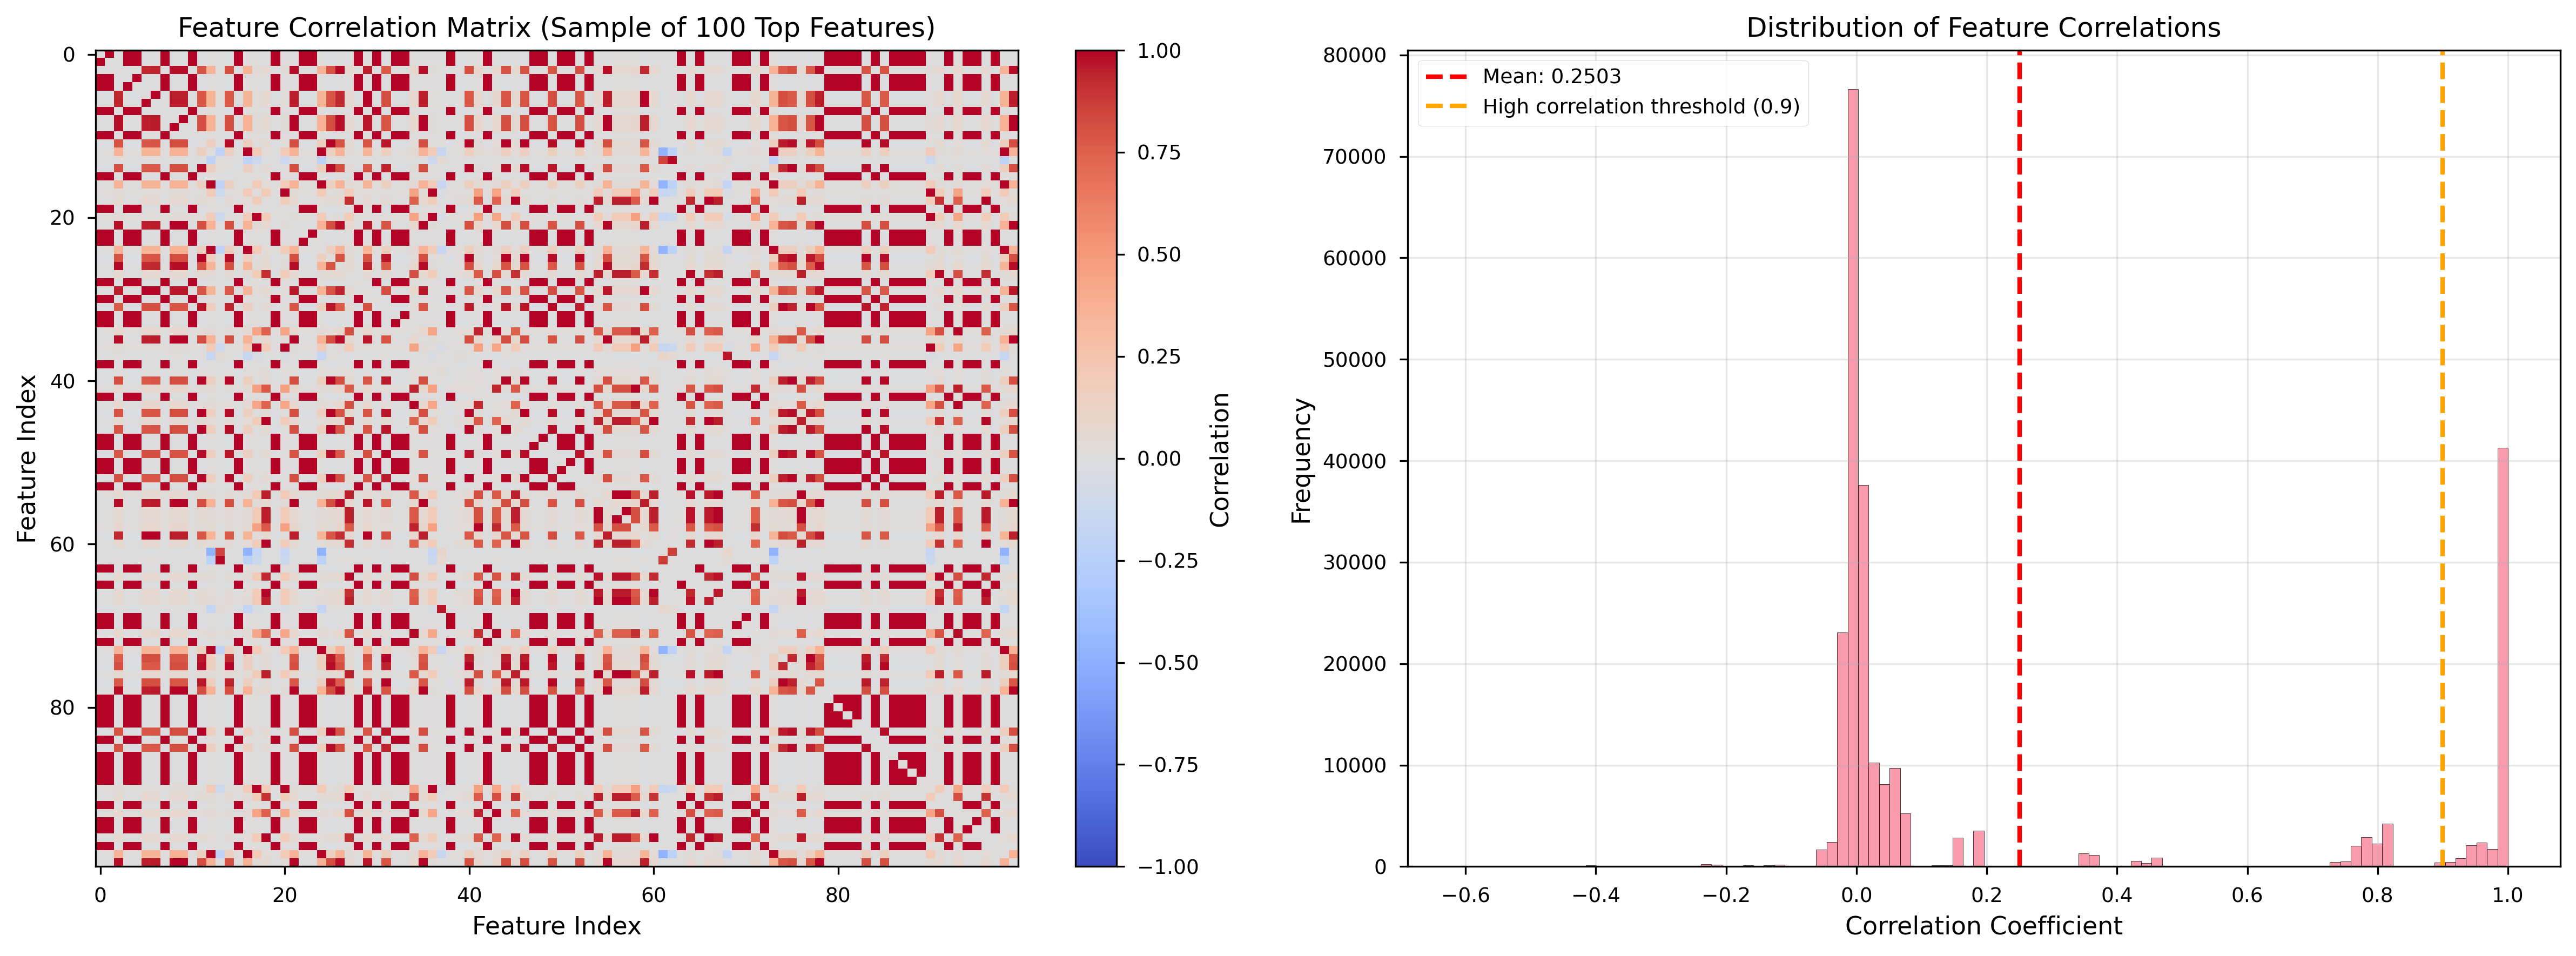

In [10]:
# Visualize correlation structure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Correlation matrix heatmap (sample of top features)
sample_size = 100
sample_indices = np.random.choice(corr_analysis['correlation_matrix'].shape[0], 
                                  size=sample_size, replace=False)
sample_corr = corr_analysis['correlation_matrix'][np.ix_(sample_indices, sample_indices)]

im = axes[0].imshow(sample_corr, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
axes[0].set_title(f'Feature Correlation Matrix (Sample of {sample_size} Top Features)')
axes[0].set_xlabel('Feature Index')
axes[0].set_ylabel('Feature Index')
plt.colorbar(im, ax=axes[0], label='Correlation')

# 2. Correlation distribution
corr_flat = corr_analysis['correlation_matrix'].flatten()
# Remove diagonal (self-correlations)
corr_flat = corr_flat[corr_flat != 0]

axes[1].hist(corr_flat, bins=100, edgecolor='black', alpha=0.7)
axes[1].axvline(np.mean(corr_flat), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {np.mean(corr_flat):.4f}')
axes[1].axvline(0.9, color='orange', linestyle='--', linewidth=2,
                label='High correlation threshold (0.9)')
axes[1].set_xlabel('Correlation Coefficient')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Feature Correlations')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/feature_correlation_analysis.png', bbox_inches='tight')
plt.show()


## 5. PCA Analysis for Compression Potential


In [11]:
# PCA analysis to understand compression potential
def perform_pca_analysis(feature_stats, n_samples=10000, max_components=500):
    """Perform PCA to understand dimensionality reduction potential"""
    # Sample features
    all_features = feature_stats['all_features']
    
    if all_features.shape[0] > n_samples:
        sample_indices = np.random.choice(all_features.shape[0], size=n_samples, replace=False)
        sampled_features = all_features[sample_indices, :]
    else:
        sampled_features = all_features
    
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(sampled_features)
    
    # Perform PCA
    print(f"Performing PCA on {features_scaled.shape[0]} samples, {features_scaled.shape[1]} features...")
    pca = PCA(n_components=min(max_components, features_scaled.shape[1]))
    features_pca = pca.fit_transform(features_scaled)
    
    return {
        'pca': pca,
        'scaler': scaler,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'cumulative_variance': np.cumsum(pca.explained_variance_ratio_),
        'components': pca.components_,
        'n_components': len(pca.explained_variance_ratio_)
    }

print("Performing PCA analysis...")
pca_results = perform_pca_analysis(feature_stats, n_samples=10000, max_components=500)

print(f"\n=== PCA Compression Analysis ===")
for n_components in [50, 100, 200, 300, 500]:
    if n_components <= len(pca_results['cumulative_variance']):
        var_explained = pca_results['cumulative_variance'][n_components - 1]
        compression_ratio = 6516 / n_components
        print(f"{n_components} components: {var_explained*100:.2f}% variance explained "
              f"(compression: {compression_ratio:.2f}x)")


Performing PCA analysis...
Performing PCA on 10000 samples, 6516 features...

=== PCA Compression Analysis ===
50 components: 97.08% variance explained (compression: 130.32x)
100 components: 99.05% variance explained (compression: 65.16x)
200 components: 99.80% variance explained (compression: 32.58x)
300 components: 99.95% variance explained (compression: 21.72x)
500 components: 99.99% variance explained (compression: 13.03x)


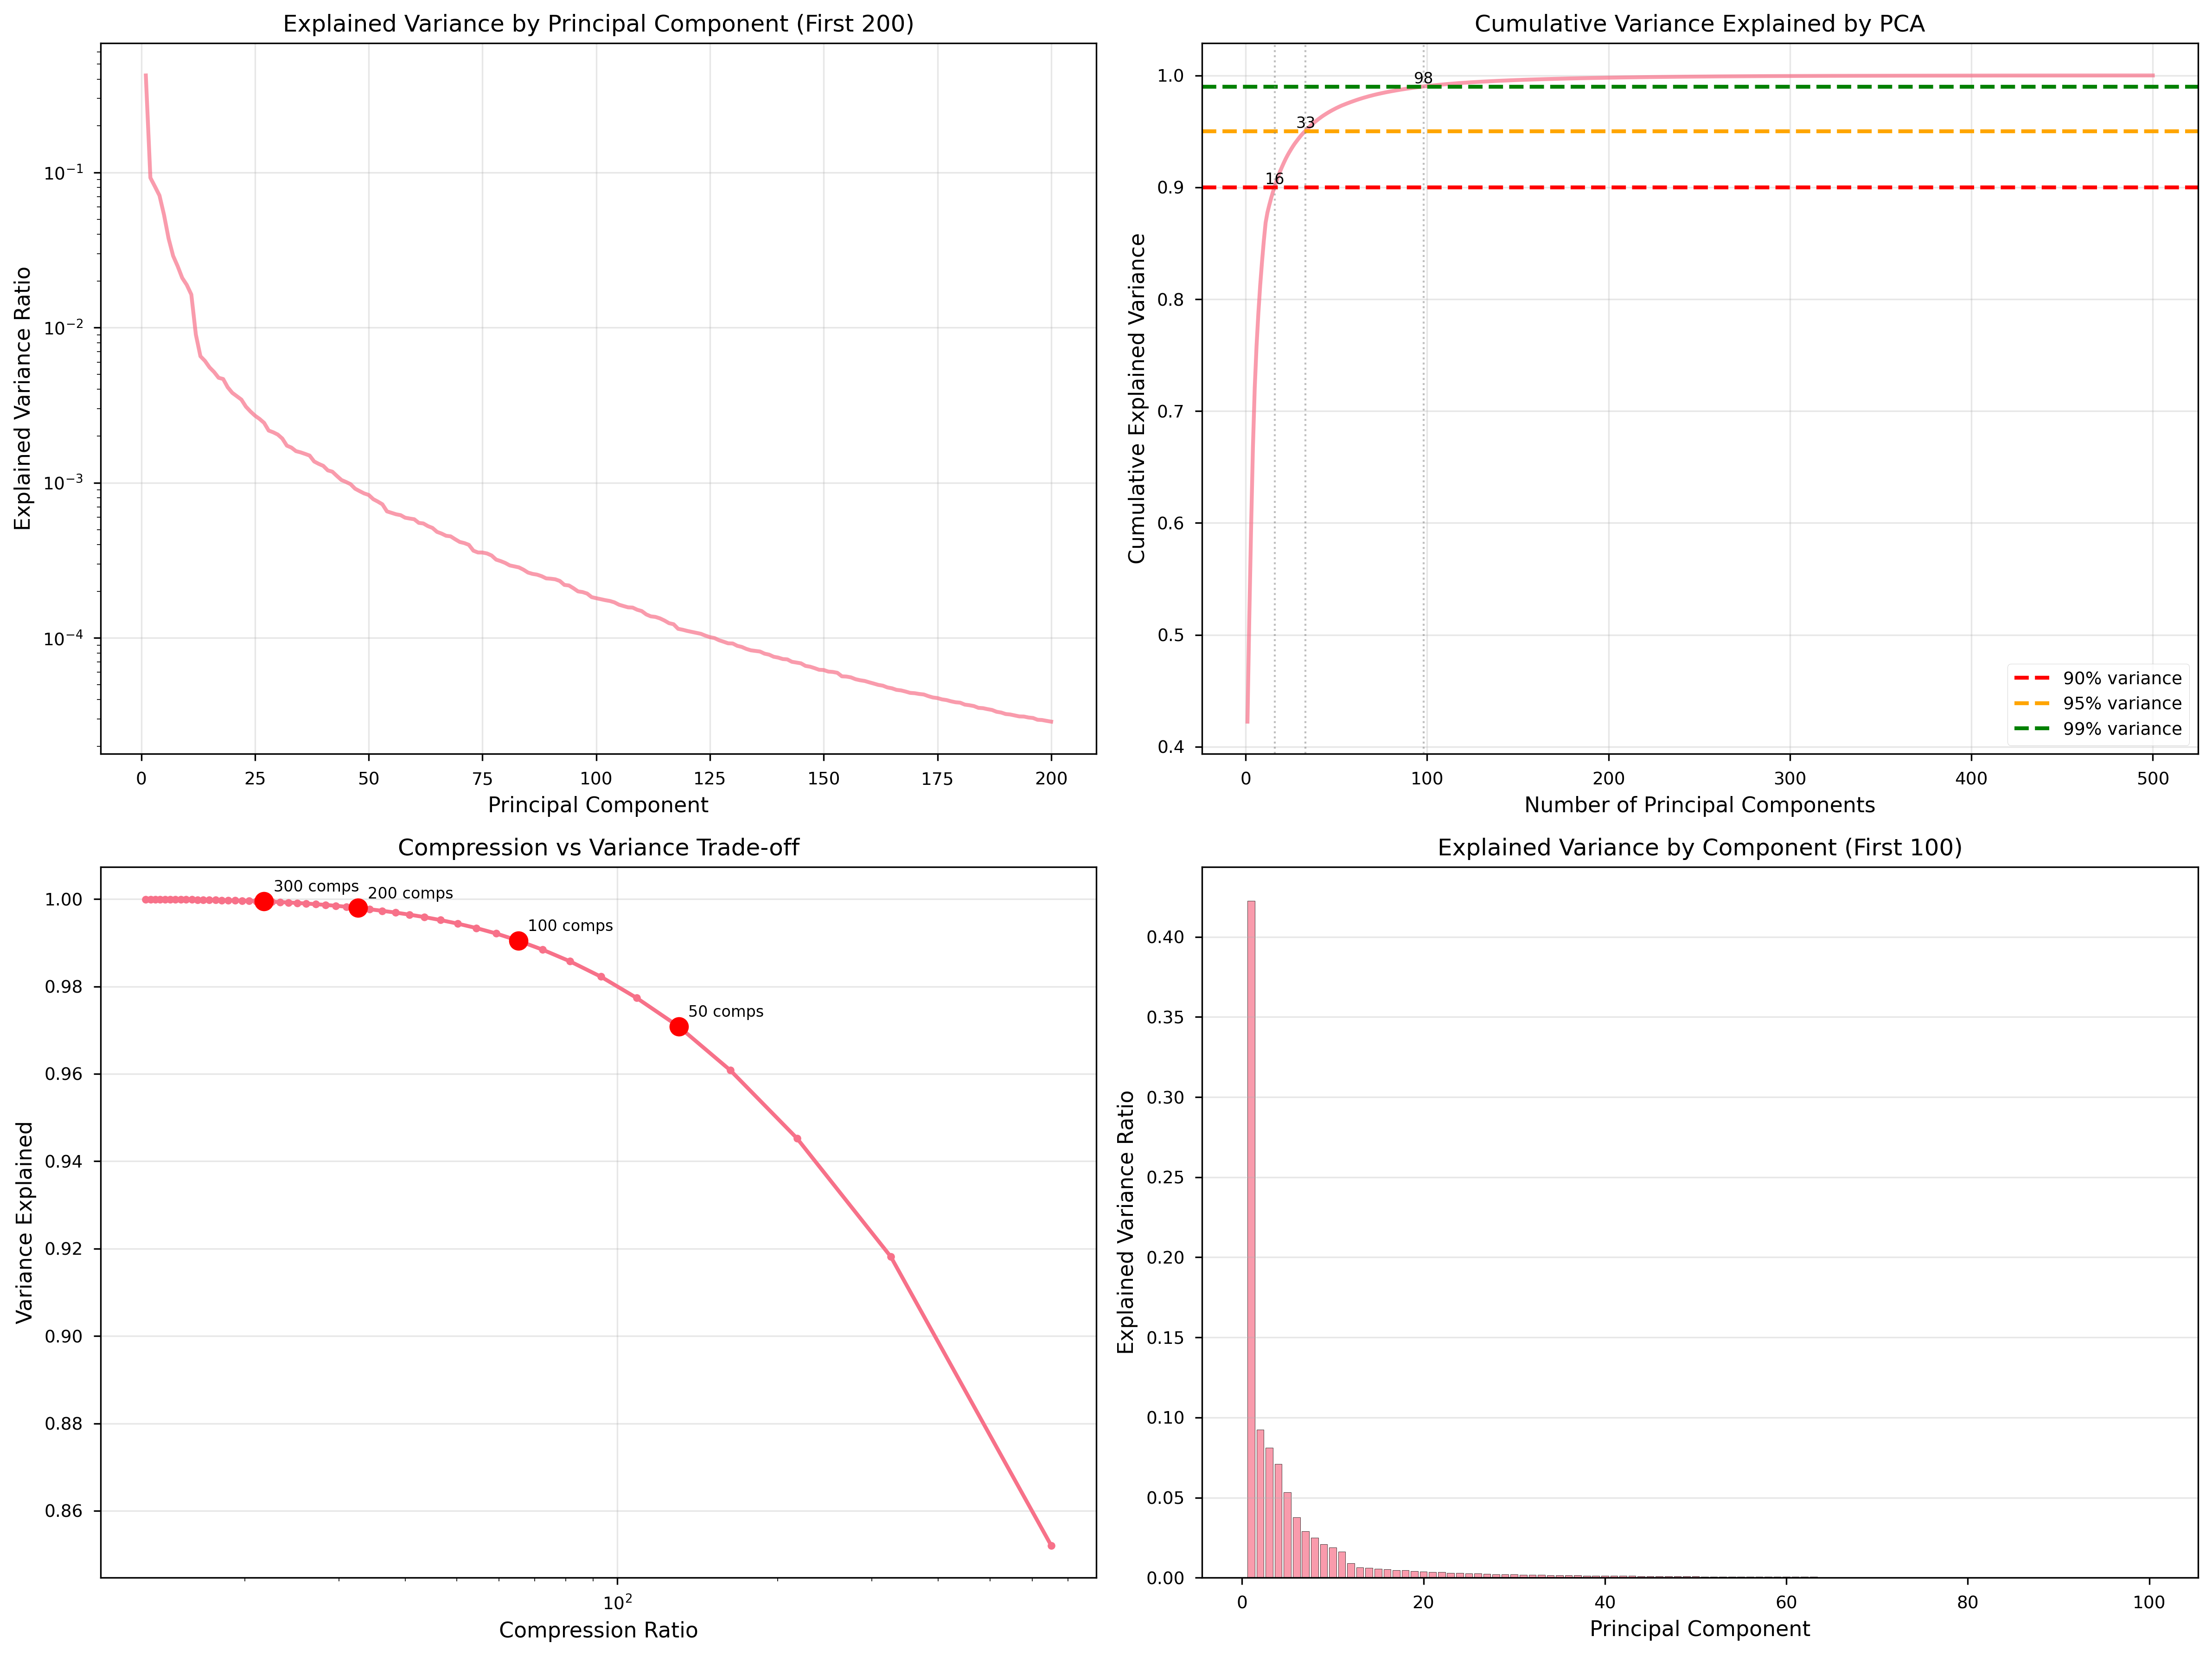

In [12]:
# Visualize PCA results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Explained variance by component
axes[0, 0].plot(range(1, min(201, len(pca_results['explained_variance_ratio']) + 1)),
                pca_results['explained_variance_ratio'][:200], 
                linewidth=2, alpha=0.7)
axes[0, 0].set_xlabel('Principal Component')
axes[0, 0].set_ylabel('Explained Variance Ratio')
axes[0, 0].set_title('Explained Variance by Principal Component (First 200)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')

# 2. Cumulative explained variance
axes[0, 1].plot(range(1, len(pca_results['cumulative_variance']) + 1),
                pca_results['cumulative_variance'], 
                linewidth=2, alpha=0.7)
axes[0, 1].axhline(0.90, color='red', linestyle='--', linewidth=2, label='90% variance')
axes[0, 1].axhline(0.95, color='orange', linestyle='--', linewidth=2, label='95% variance')
axes[0, 1].axhline(0.99, color='green', linestyle='--', linewidth=2, label='99% variance')

# Find and mark thresholds
for threshold in [0.90, 0.95, 0.99]:
    n_comp = np.argmax(pca_results['cumulative_variance'] >= threshold) + 1
    axes[0, 1].axvline(n_comp, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    axes[0, 1].text(n_comp, threshold, f'{n_comp}', 
                    ha='center', va='bottom', fontsize=8)

axes[0, 1].set_xlabel('Number of Principal Components')
axes[0, 1].set_ylabel('Cumulative Explained Variance')
axes[0, 1].set_title('Cumulative Variance Explained by PCA')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Compression ratio vs variance trade-off
n_components_range = range(10, min(501, len(pca_results['cumulative_variance']) + 1), 10)
compression_ratios = [6516 / n for n in n_components_range]
variances = [pca_results['cumulative_variance'][n-1] for n in n_components_range]

axes[1, 0].plot(compression_ratios, variances, linewidth=2, marker='o', markersize=4)
axes[1, 0].set_xlabel('Compression Ratio')
axes[1, 0].set_ylabel('Variance Explained')
axes[1, 0].set_title('Compression vs Variance Trade-off')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xscale('log')

# Highlight key points
for n_comp, comp_ratio, var in zip([50, 100, 200, 300], 
                                    [6516/50, 6516/100, 6516/200, 6516/300],
                                    [pca_results['cumulative_variance'][49],
                                     pca_results['cumulative_variance'][99] if len(pca_results['cumulative_variance']) > 99 else 0,
                                     pca_results['cumulative_variance'][199] if len(pca_results['cumulative_variance']) > 199 else 0,
                                     pca_results['cumulative_variance'][299] if len(pca_results['cumulative_variance']) > 299 else 0]):
    if var > 0:
        axes[1, 0].plot(comp_ratio, var, 'ro', markersize=10)
        axes[1, 0].annotate(f'{n_comp} comps', (comp_ratio, var), 
                            xytext=(5, 5), textcoords='offset points', fontsize=8)

# 4. Component magnitudes (first 100 components)
axes[1, 1].bar(range(1, min(101, len(pca_results['explained_variance_ratio']) + 1)),
               pca_results['explained_variance_ratio'][:100],
               edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Principal Component')
axes[1, 1].set_ylabel('Explained Variance Ratio')
axes[1, 1].set_title('Explained Variance by Component (First 100)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/pca_compression_analysis.png', bbox_inches='tight')
plt.show()


## 6. Feature Group Analysis (Hypothetical Breakdown)


In [13]:
# Attempt to identify feature groups based on patterns
# Since we have 6516 features, we can hypothesize about the structure:
# Standard MediaPipe: 2172 features (pose + hands + face)
# Additional features might include: velocities, accelerations, connections, etc.

def analyze_feature_groups(feature_stats, num_groups=10):
    """Analyze features by grouping them (hypothetical breakdown)"""
    feature_dim = len(feature_stats['vars'])
    
    # Group features into chunks (assuming they might be organized by landmark type)
    group_size = feature_dim // num_groups
    groups = []
    
    for i in range(num_groups):
        start_idx = i * group_size
        end_idx = (i + 1) * group_size if i < num_groups - 1 else feature_dim
        
        group_vars = feature_stats['vars'][start_idx:end_idx]
        group_means = feature_stats['means'][start_idx:end_idx]
        
        groups.append({
            'indices': (start_idx, end_idx),
            'mean_variance': np.mean(group_vars),
            'total_variance': np.sum(group_vars),
            'mean_value': np.mean(group_means),
            'size': end_idx - start_idx
        })
    
    return groups

feature_groups = analyze_feature_groups(feature_stats, num_groups=20)

print("=== Feature Group Analysis (Hypothetical 20 Groups) ===")
print(f"Group size: ~{6516 // 20} features per group")
print("\nGroup Statistics:")
for i, group in enumerate(feature_groups):
    print(f"Group {i+1:2d} [dim {group['indices'][0]:4d}-{group['indices'][1]:4d}]: "
          f"mean_var={group['mean_variance']:.4f}, total_var={group['total_variance']:.4f}")


=== Feature Group Analysis (Hypothetical 20 Groups) ===
Group size: ~325 features per group

Group Statistics:
Group  1 [dim    0- 325]: mean_var=0.0148, total_var=4.8073
Group  2 [dim  325- 650]: mean_var=0.0047, total_var=1.5167
Group  3 [dim  650- 975]: mean_var=0.0046, total_var=1.5060
Group  4 [dim  975-1300]: mean_var=0.0047, total_var=1.5331
Group  5 [dim 1300-1625]: mean_var=0.0047, total_var=1.5276
Group  6 [dim 1625-1950]: mean_var=0.0047, total_var=1.5147
Group  7 [dim 1950-2275]: mean_var=0.0303, total_var=9.8581
Group  8 [dim 2275-2600]: mean_var=0.0043, total_var=1.3895
Group  9 [dim 2600-2925]: mean_var=0.0042, total_var=1.3790
Group 10 [dim 2925-3250]: mean_var=0.0042, total_var=1.3805
Group 11 [dim 3250-3575]: mean_var=0.0044, total_var=1.4237
Group 12 [dim 3575-3900]: mean_var=0.0045, total_var=1.4536
Group 13 [dim 3900-4225]: mean_var=0.0109, total_var=3.5337
Group 14 [dim 4225-4550]: mean_var=0.0254, total_var=8.2395
Group 15 [dim 4550-4875]: mean_var=0.0108, total_

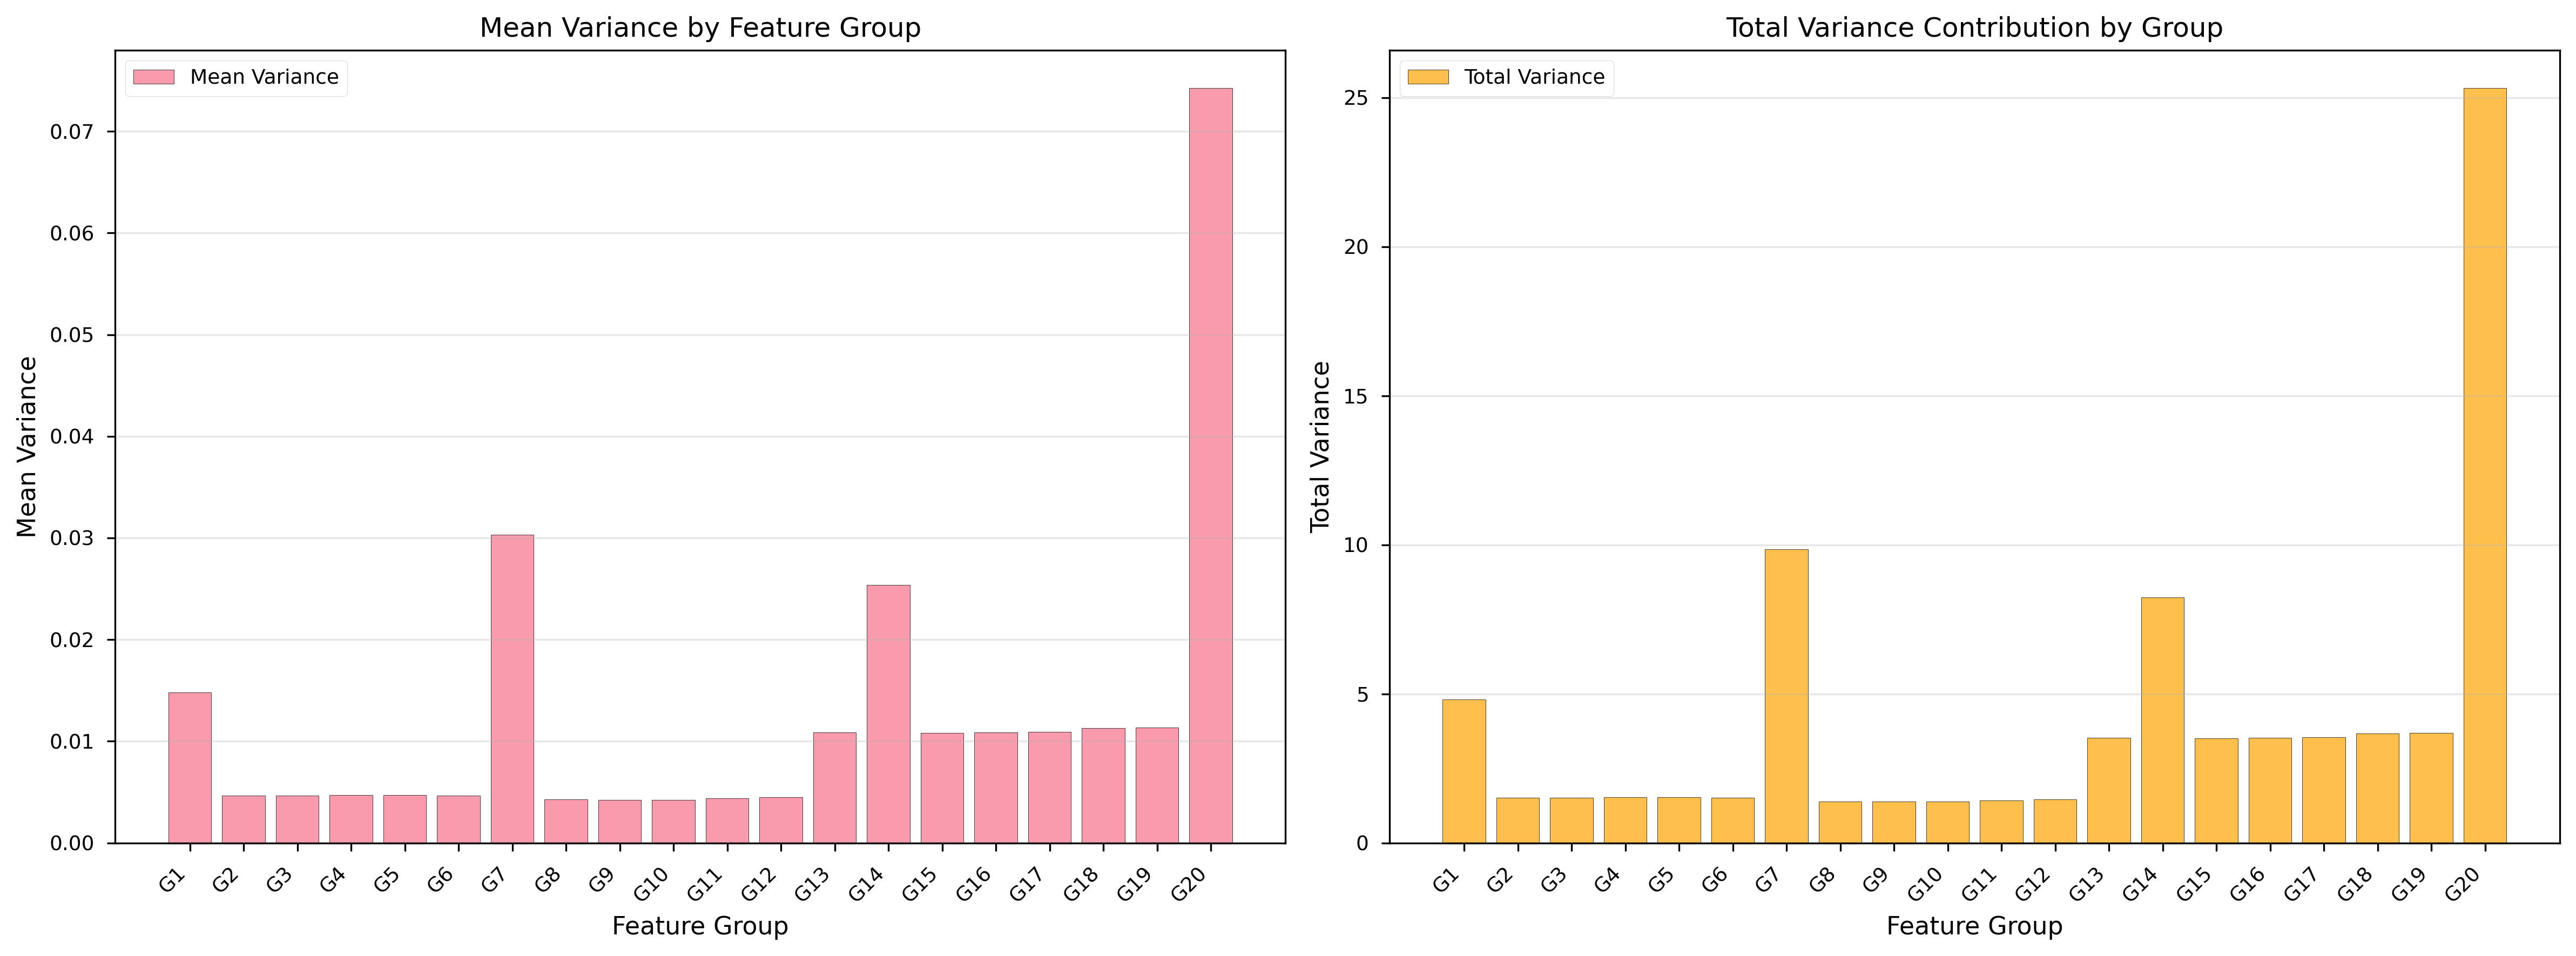

In [14]:
# Visualize feature groups
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Mean variance by group
group_indices = range(len(feature_groups))
mean_vars = [g['mean_variance'] for g in feature_groups]
total_vars = [g['total_variance'] for g in feature_groups]

axes[0].bar(group_indices, mean_vars, edgecolor='black', alpha=0.7, label='Mean Variance')
axes[0].set_xlabel('Feature Group')
axes[0].set_ylabel('Mean Variance')
axes[0].set_title('Mean Variance by Feature Group')
axes[0].set_xticks(group_indices)
axes[0].set_xticklabels([f'G{i+1}' for i in group_indices], rotation=45, ha='right')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].legend()

# 2. Total variance by group
ax2 = axes[1]
ax2.bar(group_indices, total_vars, edgecolor='black', alpha=0.7, color='orange', label='Total Variance')
ax2.set_xlabel('Feature Group')
ax2.set_ylabel('Total Variance')
ax2.set_title('Total Variance Contribution by Group')
ax2.set_xticks(group_indices)
ax2.set_xticklabels([f'G{i+1}' for i in group_indices], rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')
ax2.legend()

plt.tight_layout()
plt.savefig('figures/feature_group_analysis.png', bbox_inches='tight')
plt.show()


## 7. Summary and Compression Recommendations


In [15]:
# Create comprehensive summary
print("="*80)
print("FEATURE ANALYSIS SUMMARY AND COMPRESSION RECOMMENDATIONS")
print("="*80)

print("\n1. FEATURE CHARACTERISTICS")
print(f"   - Total feature dimensions: 6516")
print(f"   - Features with zero variance: {np.sum(feature_stats['vars'] < 1e-8)}")
print(f"   - Features with very low variance (<0.001): {np.sum(feature_stats['vars'] < 0.001)}")
print(f"   - Mean feature variance: {np.mean(feature_stats['vars']):.6f}")
print(f"   - Mean coefficient of variation: {np.mean(feature_stats['coefficient_of_variation']):.4f}")

print("\n2. COMPRESSION POTENTIAL")
if 'pca_results' in locals():
    for n_comp in [100, 200, 300, 500]:
        if n_comp <= len(pca_results['cumulative_variance']):
            var = pca_results['cumulative_variance'][n_comp - 1]
            comp_ratio = 6516 / n_comp
            print(f"   - {n_comp} PCA components: {var*100:.1f}% variance, {comp_ratio:.1f}x compression")

# Variance-based compression
sorted_vars = np.sort(feature_stats['vars'])[::-1]
cumulative_var = np.cumsum(sorted_vars) / np.sum(feature_stats['vars'])
for threshold in [0.90, 0.95, 0.99]:
    n_feat = np.argmax(cumulative_var >= threshold) + 1
    comp_ratio = 6516 / n_feat
    print(f"   - Top {n_feat} features by variance: {threshold*100:.0f}% variance, {comp_ratio:.1f}x compression")

print("\n3. CORRELATION ANALYSIS")
if 'corr_analysis' in locals():
    print(f"   - Mean absolute correlation: {corr_analysis['mean_abs_correlation']:.4f}")
    print(f"   - High correlation pairs (|r| > 0.9): {len(corr_analysis['high_corr_pairs'][0])}")
    print(f"   - Redundancy: {len(corr_analysis['high_corr_pairs'][0]) / (500*499/2) * 100:.2f}% of top 500 features")

print("\n4. RECOMMENDATIONS FOR STUDENT MODEL")
print("   Strategy 1: Variance-based feature selection")
print("     - Select top 500-1000 features by variance")
print("     - Expected compression: 6.5x - 13x")
print("     - Maintains most informative features")
print("")
print("   Strategy 2: PCA-based compression")
print("     - Use 200-300 PCA components")
print("     - Expected compression: 22x - 33x")
print("     - Captures 95-99% of variance")
print("     - Linear transformation, easy to apply")
print("")
print("   Strategy 3: Hybrid approach")
print("     - Remove low-variance features first")
print("     - Apply PCA to remaining features")
print("     - Combine with learned feature selection in student model")
print("")
print("   Strategy 4: Learned compression")
print("     - Use encoder network in student model")
print("     - Train end-to-end with knowledge distillation")
print("     - Automatically learns optimal compression")

print("\n5. MEMORY ESTIMATES (Student Model)")
print("   Assuming BiLSTM with attention:")
print("   - Input: 6516 dims → 200 dims (PCA) → 3.3x compression")
print("   - Sequence length: ~150 frames average")
print("   - Estimated memory per sequence: ~200 * 150 * 4 bytes = 120KB")
print("   - Batch size 32: ~3.8MB per batch")
print("   - With gradient checkpointing: ~50% reduction → ~1.9MB per batch")

print("\n" + "="*80)
print("\nAll visualizations saved to 'figures/' directory")
print("Ready for thesis documentation and model design decisions.")


FEATURE ANALYSIS SUMMARY AND COMPRESSION RECOMMENDATIONS

1. FEATURE CHARACTERISTICS
   - Total feature dimensions: 6516
   - Features with zero variance: 8
   - Features with very low variance (<0.001): 2039
   - Mean feature variance: 0.012943
   - Mean coefficient of variation: 942796.0000

2. COMPRESSION POTENTIAL
   - 100 PCA components: 99.0% variance, 65.2x compression
   - 200 PCA components: 99.8% variance, 32.6x compression
   - 300 PCA components: 99.9% variance, 21.7x compression
   - 500 PCA components: 100.0% variance, 13.0x compression
   - Top 1888 features by variance: 90% variance, 3.5x compression
   - Top 2577 features by variance: 95% variance, 2.5x compression
   - Top 4092 features by variance: 99% variance, 1.6x compression

3. CORRELATION ANALYSIS
   - Mean absolute correlation: 0.2602
   - High correlation pairs (|r| > 0.9): 48904
   - Redundancy: 39.20% of top 500 features

4. RECOMMENDATIONS FOR STUDENT MODEL
   Strategy 1: Variance-based feature selection
 